In [12]:
import mlflow
import mlflow.tensorflow
from dust_extinction.parameter_averages import CCM89
import astropy.units as u
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from datetime import datetime

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d
import glob
from scipy import interpolate

from SpectraVAE import SpectraVAE
from BandPassVAE import BandPassVAE
from ParamVAE import ParamVAE
from ParamVAEapply import ParamVAEapply
from validate_HSC import validate_HSC


now = datetime.now()
date_str = now.strftime("%Y%m%d%H%M%S")

print(date_str)

fig_path = "/data/kirg/MMVAE/MLFlow"
weight_path = os.path.join("/data/kirg/MMVAE/cigale/", date_str)
os.makedirs(weight_path, exist_ok=True)

20260219173102


In [13]:
from tensorflow.python.client import device_lib

devices = device_lib.list_local_devices()
for device in devices:
    if device.device_type == 'GPU':
        print(device)

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 20022099968
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6783299337309244982
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419



I0000 00:00:1771518662.897790 1130617 gpu_device.cc:2019] Created device /device:GPU:0 with 19094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
beta = np.array([1e-5, 0, 0])

beta = beta / 100.0

epochs = 150
latent_dim = 8
batch_size = 128
n_param = 4
save_train = True
tbl_train_name = 'train_dataset_cigale_tmpl.fits'
tbl_path = weight_path #'/data/kirg/MMVAE/datasets'


In [15]:
from mkdataset_cigale import *
import matplotlib.pyplot as plt
from astropy.table import Table

integrals, params, spectra, wl_spec = mkdataset_cigale(n_z=10, z_min=-0.20, z_max=1.50,
                                                       perturbation_sigmas = [0.001] * 5,
                                                       inp_file='exp_cigale_noeml.fits')
params[:, 1] = np.log10(params[:, 1])
params[:, 2] *=0.1

1000


In [16]:
perm = np.random.permutation(len(integrals))

# Apply the same permutation to all three
integrals_shuffled = integrals[perm]
params_shuffled = params[perm]
spectra_shuffled = spectra[perm]

# Postprocessing (params normalization already done in DatasetBuilder)
# Normalize spectra (just in case, or omit if confident)
#spectra /= np.max(spectra, axis=1)[:, None]


if save_train:
    tbl = Table([integrals_shuffled, params_shuffled, spectra_shuffled], names=('SED', 'Param', 'Spec'))
    tbl.write(os.path.join(tbl_path, tbl_train_name), overwrite=True)

In [17]:
def call(self, data):
    data_in  = data
    z_mean, z_log_var, z = self.encoder(data_in)
    reconstruction = self.decoder(z)
    return reconstruction

def apply(self, data):
    data_in = data
    z_mean, z_log_var, z = self.encoder(data_in)
    reconstruction = self.decoder(z)
    return (z_mean, z_log_var, z, reconstruction)

def train_step(self, data):
    (data_in, data_out) = data[0]
    with tf.GradientTape() as tape:
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        
        reconstruction_loss = ops.mean(
            tf.keras.backend.square(data_out - reconstruction)
            #tf.keras.backend.square(data_out - reconstruction)
        )
                    
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss,
   }

def test_step(self, data):
    print(data)
    (data_in, data_out) = data[0]
    (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
    reconstruction_loss = ops.mean(
        tf.keras.backend.square(data_out - reconstruction)
        #tf.keras.backend.square(data_out - reconstruction)
    )
    kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
    kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
    total_loss = reconstruction_loss + kl_loss*self.beta
    return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss,
    }


In [21]:
import types

spvae = SpectraVAE(100, latent_dim, beta=beta[0])
spvae.compile(optimizer=keras.optimizers.Adam())
spvae(tf.zeros((1, 100)))




parvae = ParamVAE(100, latent_dim, 
                  spvae, beta=beta[2],
                  n_param=n_param,
                  wei = [1,1,1,1])
parvae.compile(optimizer=keras.optimizers.Adam())
parvae(tf.zeros((1, 100)))


bpvae = BandPassVAE(5,latent_dim, spvae, beta=beta[1])
bpvae.compile(optimizer=keras.optimizers.Adam())
bpvae(tf.zeros((1, 5)))


parvaeapply = ParamVAEapply(5,latent_dim, bpvae, parvae, beta=beta[2])



parvaeapply.apply = types.MethodType(apply, parvaeapply)
parvaeapply.train_step = types.MethodType(train_step, parvaeapply)
parvaeapply.test_step = types.MethodType(test_step, parvaeapply)


parvaeapply.encoder.trainable = True
parvaeapply.decoder.trainable = True






save_path_sp = os.path.join(weight_path, 'epochs/ParVAEapply/')
os.makedirs(save_path_sp, exist_ok=True)


checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(save_path_sp, 'weights_epoch_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)


parvaeapply.compile(optimizer=keras.optimizers.Adam())
parvaeapply(tf.zeros((1, 5)))


hsp=parvaeapply.fit((integrals, params), epochs=epochs, batch_size=batch_size, validation_split=0.2,
                    callbacks=[checkpoint_cb])


Epoch 1/150


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_76']
Received: inputs=Tensor(shape=(1, 100))
  warnings.warn(msg)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_102']
Received: inputs=Tensor(shape=(1, 5))
  warnings.warn(msg)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_102']
Received: inputs=Tensor(shape=(128, 5))
  warnings.warn(msg)


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 1.7164 - loss: 0.2082 - reconstruction_loss: 0.2082((<tf.Tensor 'data:0' shape=(None, 5) dtype=float32>, <tf.Tensor 'data_1:0' shape=(None, 4) dtype=float32>),)


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_102']
Received: inputs=Tensor(shape=(None, 5))
  warnings.warn(msg)



Epoch 1: saving model to /data/kirg/MMVAE/cigale/20260219173102/epochs/ParVAEapply/weights_epoch_01.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - kl_loss: 1.7166 - loss: 0.2082 - reconstruction_loss: 0.2082 - val_kl_loss: 1.8284 - val_loss: 0.6729 - val_reconstruction_loss: 0.6729
Epoch 2/150
609/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 1.7537 - loss: 0.1721 - reconstruction_loss: 0.1721
Epoch 2: saving model to /data/kirg/MMVAE/cigale/20260219173102/epochs/ParVAEapply/weights_epoch_02.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 1.7554 - loss: 0.1723 - reconstruction_loss: 0.1723 - val_kl_loss: 1.7840 - val_loss: 0.7091 - val_reconstruction_loss: 0.7091
Epoch 3/150
571/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 1.7139 - loss: 0.1724 - reconstruction_loss: 0.1724
Epoch 3: saving model to /data/kirg/MMVAE/cigale/20260219173102/epochs/ParVAEapply/weights_epoch_03.weights.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 1.7131 - loss: 0.1724 - 

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_102']
Received: inputs=Tensor(shape=(100000, 5))
  warnings.warn(msg)


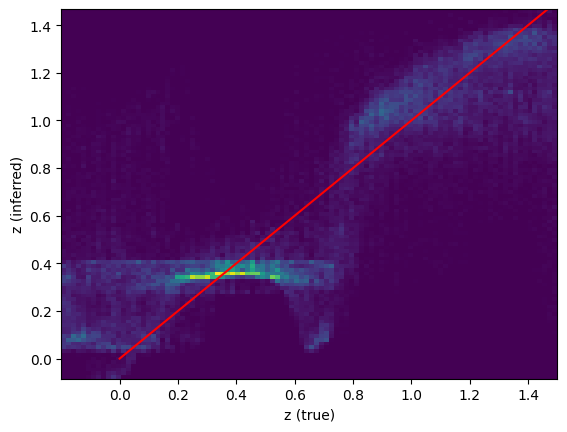

In [ ]:
s = parvaeapply(integrals)
s_sel = s
params_sel = params
plt.hist2d(params_sel[:, 0], s_sel[:, 0], bins=100)
plt.xlabel('z (true)')
plt.ylabel('z (inferred)')
plt.plot([0,1.5], [0,1.5], color='red')
plt.show()

plt.plot(params_sel[:, 0], s_sel[:, 0], 'k.', alpha=0.002)
plt.xlabel('z (true)')
plt.ylabel('z (inferred)')
plt.plot([0,1.5], [0,1.5], color='red')
plt.show()


/home/kirg/MMVAE/vae_mpoe/validate_HSC.py:25: UserWarning: Warning: converting a masked element to nan.
  mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_64']
Received: inputs=Tensor(shape=(174304, 5))
  warnings.warn(msg)


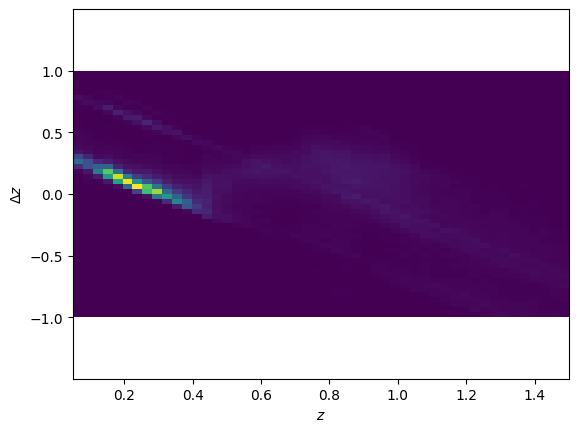

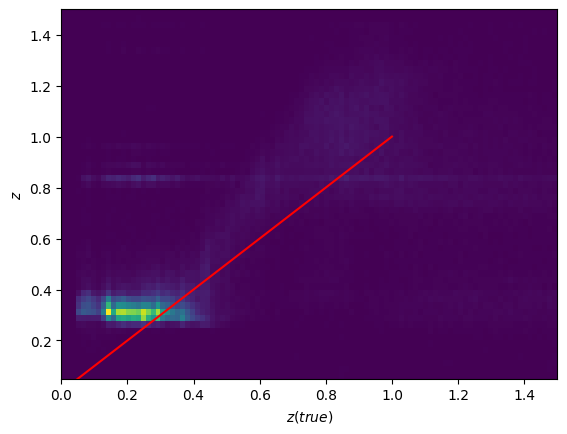

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_64']
Received: inputs=Tensor(shape=(160762, 5))
  warnings.warn(msg)


tf.Tensor([0.86899126 1.8734157  0.66390216 0.02930943], shape=(4,), dtype=float32) 0.822681493570212


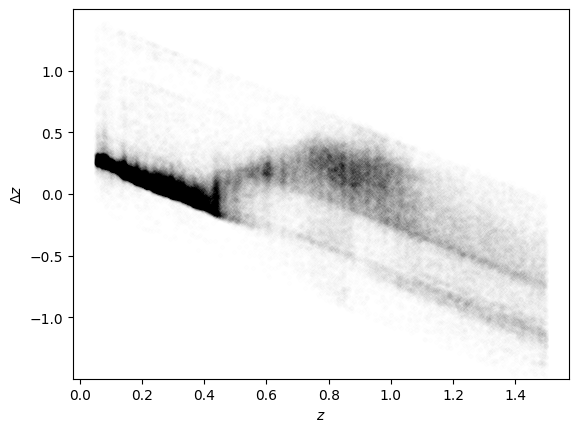

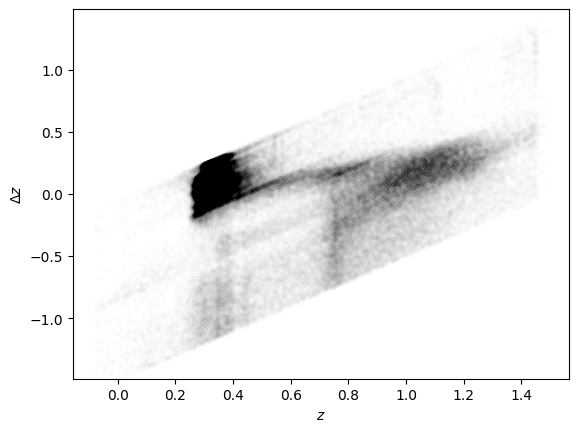

[0.82268149 0.78530661 0.78958418 ... 0.0872988  0.0873343  0.15478596]


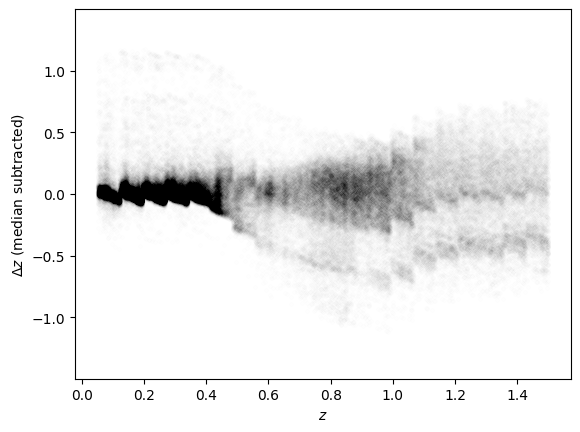

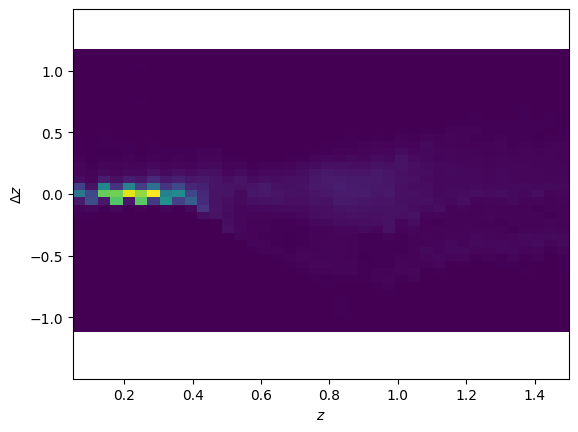

0.08437658764971312 -0.0043974966 0.03900303
0.1609518218259867 -0.0037706643 0.037260257
0.23224574072286575 -0.0043927208 0.034982637
0.3005030542082366 -0.006316051 0.03668786
0.3729144105629544 -0.008639798 0.045560487
0.4446966716478358 -0.012422696 0.1130453
0.5197335356044075 -0.0047257245 0.16647777
0.5938853787654966 0.016907632 0.09772837
0.6671444408673443 0.017507404 0.11465632
0.7426516752135683 0.03552875 0.15039094
0.8132416903009981 0.03780365 0.1590557
0.8829454610983705 0.019154936 0.1722512
0.9562775539020024 0.022102207 0.19040617
1.0278397035317333 0.040466964 0.21862808
1.098601086032606 0.0023982823 0.3048786
1.173570685105528 0.0009974837 0.32091796
1.2449487916804096 0.0006017089 0.3174527
1.3181538923260399 0.00019878149 0.32628113
1.3911223519634741 0.00022912025 0.32766837
1.4637685905658395 -2.9802322e-08 0.3291121


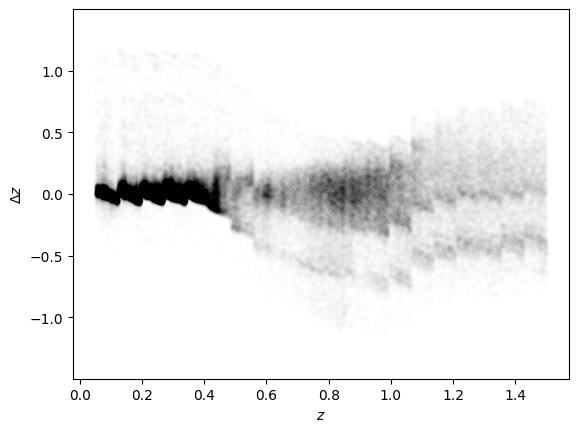

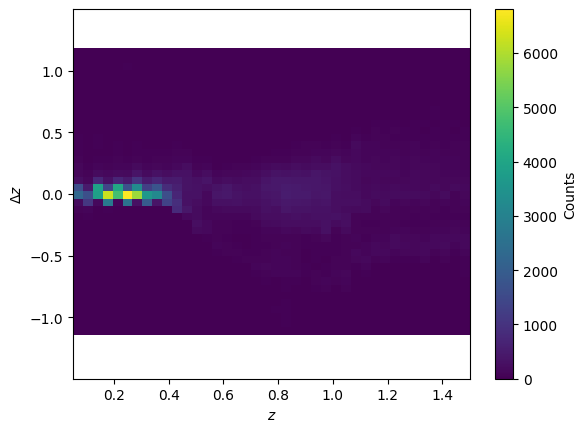

In [20]:
from validate_HSC import validate_HSC


filename = ['test1.png',
           'test2.png',
           'test3.png',
           'test4.png',
           'test5.png',
           'test6.png',
           'test7.png']

validate_HSC(parvaeapply, filename, fig_path='/home/kirg/fig_test',
             show = [True, True, True, True, True, True, True],
             hsc_table='DESI_DR1_HSCSSP_clean_v2.fits', 
             z_min=0.05, z_max=1.50,
             hist2d_zz_kwargs=dict(bins=100, range=[[0, 1.5], [-0.5, 1.5+0.5]]))
